In [2]:
# setting this env to "" will make pytorch run on CPU
# Reference: https://stackoverflow.com/questions/53266350/how-to-tell-pytorch-to-not-use-the-gpu
%env CUDA_VISIBLE_DEVICES=""

env: CUDA_VISIBLE_DEVICES=""


In [3]:
import os

os.environ["CUDA_VISIBLE_DEVICES"]

'""'

In [4]:
# These should run on the CPU
import torch

x = torch.rand(5, 3)
print(x)
print(torch.backends.cudnn.enabled)
print(torch.cuda.is_available())

tensor([[0.8517, 0.6399, 0.5222],
        [0.9945, 0.0884, 0.4080],
        [0.0617, 0.8589, 0.7609],
        [0.0206, 0.3331, 0.3501],
        [0.2227, 0.3809, 0.9911]])
True
False


In [5]:
from pathlib import Path


def find_project_root(current_dir: Path) -> Path:
    for parent in current_dir.parents:
        child_dirs = map(lambda sub: Path(parent) / sub, os.listdir(str(parent)))
        for subfolder in child_dirs:
            if subfolder.is_dir() and subfolder.name == ".git":
                return parent

In [6]:
# for the bing image search to work
# place a json of the following structure
# { "key": "<search_api_key>"} in the path available to
# this notebook

import json
import os

project_root = find_project_root(Path(os.curdir).absolute())
key_file_path = project_root / ".secrets/bing_image_search.json"
with open(key_file_path) as key_file:
    secret = json.load(key_file)

secret.keys()

dict_keys(['key'])

In [7]:
from fastai.vision import widgets
from fastai.vision.all import *

In [7]:
from typing import List


# Response JSON Schema reference
# https://docs.microsoft.com/en-us/azure/cognitive-services/bing-image-search/quickstarts/python
# {
# "_type":"Images",
# "instrumentation":{
#     "_type":"ResponseInstrumentation"
# },
# "readLink":"images\/search?q=tropical ocean",
# "webSearchUrl":"https:\/\/www.bing.com\/images\/search?q=tropical ocean&FORM=OIIARP",
# "totalEstimatedMatches":842,
# "nextOffset":47,
# "value":[
#     {
#         "webSearchUrl":"https:\/\/www.bing.com\/images\/search?view=detailv2&FORM=OIIRPO&q=tropical+ocean&id=8607ACDACB243BDEA7E1EF78127DA931E680E3A5&simid=608027248313960152",
#         "name":"My Life in the Ocean | The greatest WordPress.com site in ...",
#         "thumbnailUrl":"https:\/\/tse3.mm.bing.net\/th?id=OIP.fmwSKKmKpmZtJiBDps1kLAHaEo&pid=Api",
#         "datePublished":"2017-11-03T08:51:00.0000000Z",
#         "contentUrl":"https:\/\/mylifeintheocean.files.wordpress.com\/2012\/11\/tropical-ocean-wallpaper-1920x12003.jpg",
#         "hostPageUrl":"https:\/\/mylifeintheocean.wordpress.com\/",
#         "contentSize":"897388 B",
#         "encodingFormat":"jpeg",
#         "hostPageDisplayUrl":"https:\/\/mylifeintheocean.wordpress.com",
#         "width":1920,
#         "height":1200,
#         "thumbnail":{
#         "width":474,
#         "height":296
#         },
#         "imageInsightsToken":"ccid_fmwSKKmK*mid_8607ACDACB243BDEA7E1EF78127DA931E680E3A5*simid_608027248313960152*thid_OIP.fmwSKKmKpmZtJiBDps1kLAHaEo",
#         "insightsMetadata":{
#         "recipeSourcesCount":0,
#         "bestRepresentativeQuery":{
#             "text":"Tropical Beaches Desktop Wallpaper",
#             "displayText":"Tropical Beaches Desktop Wallpaper",
#             "webSearchUrl":"https:\/\/www.bing.com\/images\/search?q=Tropical+Beaches+Desktop+Wallpaper&id=8607ACDACB243BDEA7E1EF78127DA931E680E3A5&FORM=IDBQDM"
#         },
#         "pagesIncludingCount":115,
#         "availableSizesCount":44
#         },
#         "imageId":"8607ACDACB243BDEA7E1EF78127DA931E680E3A5",
#         "accentColor":"0050B2"
#     }]
# }
def get_image_urls(key: str, search_term: str) -> List[str]:
    results = search_images_bing(key, search_term)
    return results.attrgot("contentUrl")


# test_query = get_image_urls(secret["key"], "teddy bear")

In [8]:
bear_types = ["grizzly", "black", "teddy", "polar"]
bears_root = Path("dataset/bears")
bears_root.mkdir(parents=True, exist_ok=True)

In [ ]:
import time

bear_img_links = {}
for bear_type in bear_types:
    image_links = get_image_urls(secret["key"], f"{bear_type} bear")
    print(f"Got {len(image_links)} image links for {bear_type} bear")
    bear_img_links[bear_type] = image_links
    time.sleep(2)

bear_img_links.keys()

In [ ]:
for bear_type, image_links in bear_img_links.items():
    dest_path = bears_root / bear_type
    dest_path.mkdir(parents=True, exist_ok=True)
    download_images(dest_path, urls=image_links)
    print(f"Downloaded images for {bear_type} into {dest_path.absolute()}")

In [ ]:
# Identify and delete images that are failed to download
for bear_type in bear_types:
    fns = get_image_files(bears_root / bear_type)
    print(bear_type, len(fns))
    failed = verify_images(fns)
    print(f"failed images {len(failed)}")
    for failed_img in failed:
        failed_img.unlink()

## DataBlock and image preprocessing

In [9]:
bears = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128),
)

dls = bears.dataloaders(bears_root)

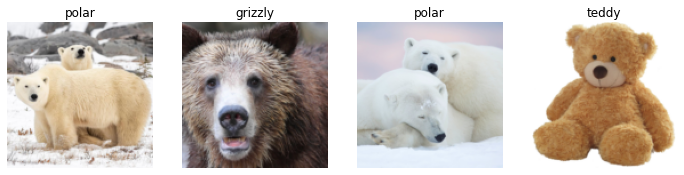

In [11]:
dls.valid.show_batch(max_n=4, nrows=1)

In [ ]:
# resize by squishing the image
bears_squished = bears.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls_squished = bears_squished.dataloaders(bears_root)
dls_squished.valid.show_batch(max_n=4, nrows=1)

In [ ]:
# resize by padding zeros
# observe the black regions in the border
bears_padded = bears.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode="zeros"))
dls_padded = bears_padded.dataloaders(bears_root)
dls_padded.valid.show_batch(max_n=4, nrows=1)

In [ ]:
# RandomResizedCrop
# min_scale = how much of the image to select for cropping and resizing
bears_rand_resized = bears.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls_rand_resized = bears_rand_resized.dataloaders(bears_root)

# This is referred to as data augmentation
# Generating additional training data from the existing training data
# unique=True to have the same image repeated with different versions of
# randomized cropping
dls_rand_resized.train.show_batch(max_n=4, nrows=1, unique=True)

In [ ]:
bears_augmented = bears.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))

dls_augmented = bears_augmented.dataloaders(bears_root)
dls_augmented.train.show_batch(max_n=8, nrows=2, unique=True)

## Training model

In [10]:
# we are using RandomResizedCrop because we only have < 150
# images for every type of the bear.
bears_train = bears.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5), batch_tfms=aug_transforms()
)
dls_train = bears_train.dataloaders(bears_root)

In [11]:
# Using convolutional neural networks, transfer learning on resnet18
# we fine_tune the resnet18 model for 4 epochs
bear_learner = cnn_learner(dls_train, resnet18, metrics=error_rate)
bear_learner.fine_tune(4)

/media/girish/HDD/code_repos/bitbucket/repos/machine_learning/.venv/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


/media/girish/HDD/code_repos/bitbucket/repos/machine_learning/.venv/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/media/girish/HDD/code_repos/bitbucket/repos/machine_learning/.venv/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/media/girish/HDD/code_repos/bitbucket/repos/machine_learning/.venv/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/media/girish/HDD/code_repos/bitbucket/repos/machine_learning/.venv/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


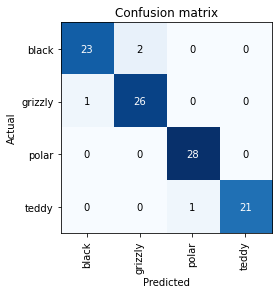

In [12]:
# error analysis of the model
interp = ClassificationInterpretation.from_learner(bear_learner)
# plots the confusion matrix of the validation dataset
interp.plot_confusion_matrix()
# rows represent actual classes
# columns represent the predictions

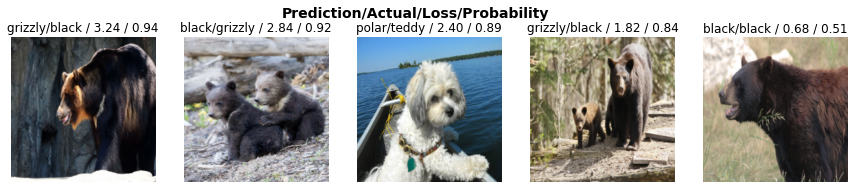

In [13]:
# a black bear is predicted as grizzly bear
interp.plot_top_losses(5, nrows=1)

In [14]:
# saving the model with the architecture as well as the trained parameters
# we might also need to save the dataloaders as they contain the transformation
# steps for predicting
model_path = Path() / "dataset/model"
model_name = "bear_recognizer.pkl"
model_path.mkdir(parents=True, exist_ok=True)

In [15]:
bear_learner.export(fname=str(model_path / model_name))

## Predicting with the saved model

In [16]:
bear_predictor = load_learner(fname=str(model_path / model_name))

In [17]:
# predict method returns the category name, category index
# and the prediction probability for each category
# The order in which the learner maintains the category can be
# accessed as follows
bear_predictor.dls.vocab

['black', 'grizzly', 'polar', 'teddy']

In [18]:
bear_predictor.predict(Path() / "dataset/prediction/grizzly.jpeg")

('grizzly',
 tensor(1),
 tensor([4.6501e-06, 9.9989e-01, 1.0294e-04, 5.8084e-07]))

In [19]:
bear_predictor.predict(Path() / "dataset/prediction/teddy.jpeg")

('teddy', tensor(3), tensor([3.4430e-08, 6.1651e-07, 7.2050e-08, 1.0000e+00]))

In [20]:
bear_predictor.predict(Path() / "dataset/prediction/black.jpeg")

('black', tensor(0), tensor([9.9402e-01, 5.9817e-03, 2.9178e-07, 4.2969e-07]))

## Create notebook app from a model

In [21]:
img_upload_btn = widgets.FileUpload()
classify_btn = widgets.Button(description="Classify")
out_pl = widgets.Output()
lbl_pred = widgets.Label()

In [22]:
def on_image_upload(change):
    img_to_predict = PILImage.create(img_upload_btn.data[-1])
    out_pl.clear_output()
    with out_pl:
        display(img_to_predict.to_thumb(128, 128))


def on_click_classify(change):
    img_to_predict = PILImage.create(img_upload_btn.data[-1])
    pred_type, pred_idx, pred_prob = bear_predictor.predict(img_to_predict)
    lbl_pred.value = f"{pred_type}, {pred_prob[pred_idx] * 100 : 0.4f}"

In [23]:
img_upload_btn.value.clear()
img_upload_btn._counter = 0
out_pl.clear_output()
lbl_pred.value = ""

img_upload_btn.observe(on_image_upload, names="value")
classify_btn.on_click(on_click_classify)

widgets.VBox(
    [widgets.Label("Select your bear image"), img_upload_btn, out_pl, classify_btn, lbl_pred]
)

In [ ]:
# install voila and enable the jupyter extension and then restart jupyter notebooks
# !pip install voila
# !jupyter serverextension enable voila --sys-prefix